## 参考文献
1. [Delayed Majority Game with Heterogeneous Learning Speeds for Financial Markets](https://doi.org/10.7566/JPSCP.16.011010)

Yushi YOSHIMURA, Kenta YAMADA(2016)

2. [Stylized facts of financial markets and market crashes in Minority Games]()

Damien Challeta, Matteo Marsilib, Yi-Cheng Zhang(2001)

#### Motivation
個々の主体の行動からどのようにして株式・外為市場に見られる経験的に知られる現象が創発するか に興味

#### Purpose

"Stylized facts" of financial markets
1. Volatility Clustering
autocorrelation functionがほぼ$n^{-0.3}$に比例することがわかっている.
3. Fat tail

Agent Based Modelにより現象の再現を目指す.

#### Previous Results

#### GCMG

GCMG = Grand Canonical Minority Game

\* minority game...minorな選択をしたほうが勝つゲーム

シンプルに市場のagentをモデル化し,上記のStylized Factを説明することに成功.

#### Model

2種類のトレーダーを考える.
1. Producers
1. Speculators

Producersは自信の経済活動の一環として市場を利用する.(現実の活動に影響されるので,Producerのみからなる市場はランダムウォークすると考えられる)
Speculatorsは市場の価格変動から利益を得る投機家. 流動性を提供する一方でProducersによるランダムウォークに影響を与える.

SpeculatorsにTradeしない選択肢を与える.(Grand Canonicalの由来)

$$
t = 1, 2, \ldots
$$
を時点とし,各tにおいてagent $i$は,購入量$a_i(t)$を選ぶ. (負なら売却の意味)

各agentのペイオフを,

$$
-a_i(t) A(t)
$$

と定める.(Minority Gameの所以) ただし,

$$
A(t) = \sum_{j = 1}^N a_j(t)
$$

である. また,時点tでの価格P(t)について,

$$
r(t) = A(t) / \lambda
$$
と置き,
$$
P(t + 1) = P(t) \exp{r(t)}
$$
と定める. $\lambda$はMarket depthに関係する.

さらに,'経済状態'を導入する.
時点tでのPublic Informationを$\mu(t)$と置く. 各$\mu(t)$は$1 \ldots P$の値を取る整数とする.

Producerは'経済状態'に応じて行動を(決定論的に)決めるとする.

SpeculatorはS+1個のStrategy$s = 0, 1, \ldots, S$を持ち,'経済状態'$\mu(t)$を観測したあと,自らにとって最良と信じるStrategyを取る. ただしStrategy$s = 0$はTradeしないというStrategy. (Strategyが何かは個々だとわかりにくいので図で)

ここで,Speculatorが最良のStrategyを取れるよう,各Speculator $i$はStrategy $s$の過去のパフォーマンスをモニタする. 

$U_{i, s}$を,$i$の$s$に対するscoreとすると,各期において $s=0$のとき
$$
U_{i, s} \leftarrow U_{i, s} + \epsilon
$$
それ以外のとき,
$$
U_{i, s} \leftarrow U_{i, s} - a^{\mu(t)}_{i, s} A(t)
$$
のようにupdateする. もしStrategy $s (\neq 0)$によるペイオフが$\epsilon$よりも大きければ$s=0$を取ることはないことを意味する.
$\epsilon$はリスクフリーレートと解釈できる.

### 実装

In [111]:
using Plots
using StatsBase
using Distributions

In [139]:
include("src/models.jl")

simulate! (generic function with 2 methods)

In [365]:
N_s = 501 # there are N_s speculators and N_p producers
N_p = 1001

P = 460 # total number of Public states (information)
S = 2 # number of active strategies each speculator has

lambda = 500.0 # UNKNOWN
epsilon = 0.01

U_s = Array{Float64}(S+1, N_s)
fill!(U_s, 0.0)
#U_s = randn(S+1, N_s)
gcmg = GCMG(N_s, N_p, P, S, lambda, U_s, epsilon=epsilon)

loops = 10000
prices_gcmg, Qs_gcmg, actives = simulate!(gcmg, loops)
returns_gcmg = log.(prices_gcmg[2:end]) .- log.(prices_gcmg[1:(end-1)])
print()

In [366]:
actives

10000-element Array{Int64,1}:
 1502
 1366
 1370
 1370
 1367
 1368
 1368
 1363
 1359
 1360
 1352
 1352
 1354
    ⋮
 1310
 1310
 1311
 1310
 1310
 1310
 1309
 1308
 1308
 1310
 1310
 1308


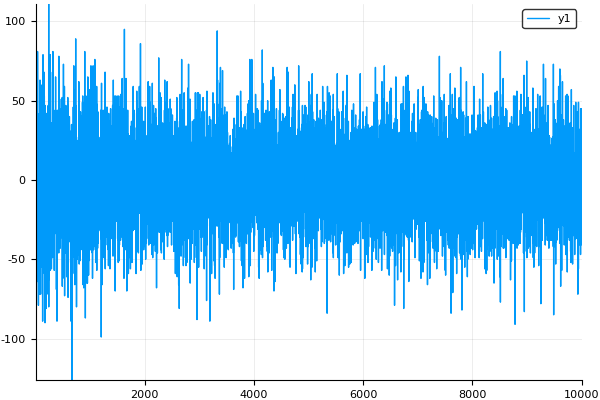

In [367]:
plot(Qs_gcmg)


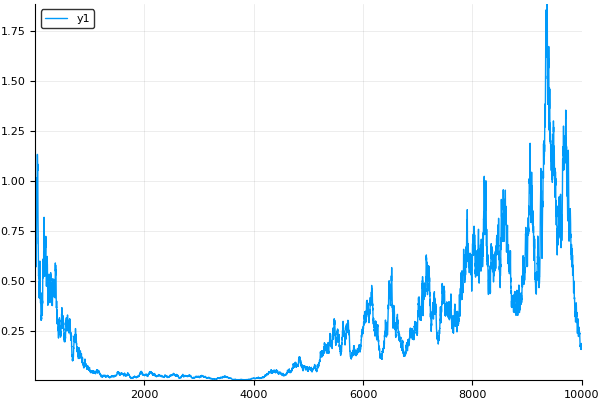

In [368]:
plot(prices_gcmg)


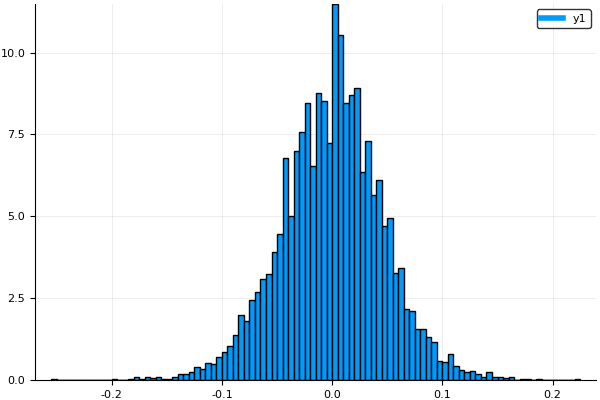

In [369]:
histogram(returns_gcmg[200:end], normed=true)
#plot!(linspace(-0.04, 0.04, 100), x -> pdf(Normal(), x))

In [370]:
kurtosis(returns_gcmg[200:end])

0.6685773523362633

(excess kurtosis)Fat-tailであることがわかる.


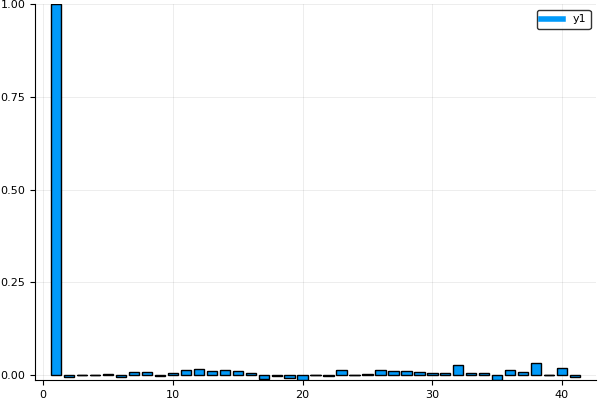

In [371]:
bar(autocor(abs.(Qs_gcmg[200:end])))

In [322]:
function get_stats_gcmg(N_s, N_p, P, S, lambda, epsilon, len, loops=1000)
    kurtosis_array = Vector{Float64}(len)
    U_s = zeros(Float64, S+1, N_s)
    gcmg = GCMG(N_s, N_p, P, S, lambda, U_s, epsilon=epsilon)
    for i in 1:len
        gcmg = initialize_GCMG(gcmg) # to save memory
        prices_gcmg, _, _ = simulate!(gcmg, loops)
        returns_gcmg = log.(prices_gcmg[2:end]) .- log.(prices_gcmg[1:(end-1)])
        kurtosis_array[i] = kurtosis(returns_gcmg[200:end])
    end
    return kurtosis_array
end

get_stats_gcmg (generic function with 2 methods)

In [332]:
len = 500
loops = 1000
kurtosis_array = get_stats_gcmg(N_s, N_p, P, S, lambda, epsilon, len, loops)

500-element Array{Float64,1}:
  4.12758  
  1.5081   
  1.02607  
  0.514173 
  0.756808 
  0.335474 
  0.583661 
 -0.0169636
  0.38077  
  0.347103 
  0.437163 
  0.320715 
  0.866673 
  ⋮        
  0.347769 
 -0.395074 
 -0.511314 
  0.121432 
  0.25891  
  0.709616 
  0.325022 
 -0.355464 
  0.0970338
 -0.0771555
  0.0909186
  0.437175 


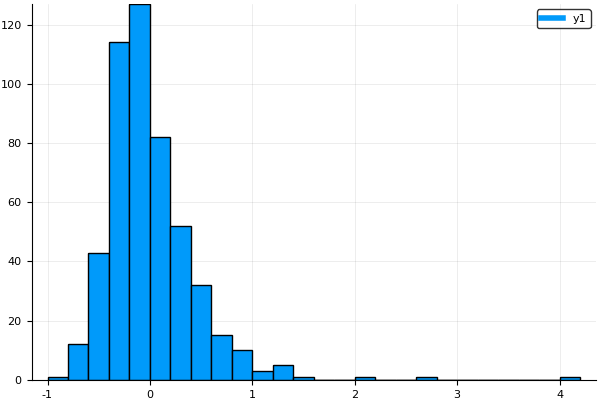

In [333]:
histogram(kurtosis_array)

In [334]:
sum(kurtosis_array .> 0)

203

In [335]:
sum(kurtosis_array .< 0)

297

#### Problems

パラメーターに敏感すぎる.

<!--N = 1000 # there are N agents

P = 32 # total number of Public states (information)
S = 2 # number of active strategies each speculator has

lambda = 2.0
P_irr = 0.98
beta = Vector{Float64}(N)
fill!(beta[1:div(N, 2)], 0.1)
fill!(beta[div(N, 2)+1:end], 0.1)
U0 = 0.00482

dmghls = DMGHLS(N, P, S, lambda, P_irr, U0, beta, seed=0)

loops = 1000
prices_dmghls, inactives = simulate!(dmghls, loops, seed=0)
returns_dmghls = log.(prices_dmghls[2:end]) .- log.(prices_dmghls[1:(end-1)])
print()-->

## Delayed Majority Game with Homogenous Learning Speeds

In [14]:
N = 1000 # there are N agents

P = 32 # total number of Public states (information)
S = 2 # number of active strategies each speculator has

lambda = 2.0
P_irr = 0.2
beta = Vector{Float64}(N)
fill!(beta, 0.1)
U = Array{Float64}(S+1, N)
fill!(U, 0.001787)

dmghls = DMGHLS(N, P, S, lambda, P_irr, U, beta, seed=0)

loops = 10000
prices_dmghls, actives = simulate!(dmghls, loops, seed=0)
returns_dmghls = log.(prices_dmghls[2:end]) .- log.(prices_dmghls[1:(end-1)])
print()


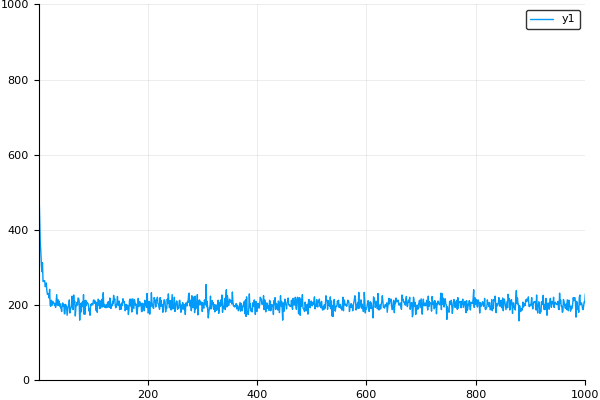

In [15]:
plot(actives[1:10:end], ylim=(0, N))

In [16]:
plot(prices_dmghls)

ArgumentError: [91mArgumentError: At least one finite value must be provided to formatter.[39m


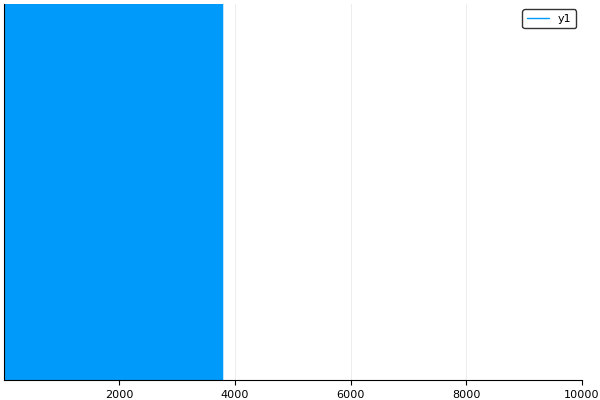

In [17]:
plot(returns_dmghls)

In [18]:
histogram(returns_dmghls)

LoadError: [91mArgumentError: quantiles are undefined in presence of NaNs[39m

In [19]:
kurtosis(returns_dmghls[200:end])

NaN

In [20]:
skewness(returns_dmghls[200:end])

NaN

In [21]:
bar(autocor(abs.(returns_dmghls[200:end])))

DivideError: [91mDivideError: integer division error[39m

In [43]:
N = 1000 # there are N agents

P = 32 # total number of Public states (information)
S = 2 # number of active strategies each speculator has

lambda = 2.0
P_irr = 0.07
beta = Vector{Float64}(N)
fill!(beta, 0.1)
U0_range = 0.0:0.0005:0.01
loops = 1000
kurtosis_array = Vector{Float64}(length(U0_range))

for (i, U0) in enumerate(U0_range)
    U = Array{Float64}(S+1, N)
    fill!(U, U0)
    dmghls = DMGHLS(N, P, S, lambda, P_irr, U, beta, seed=0)
    prices_dmghls, _ = simulate!(dmghls, loops, seed=0)
    returns_dmghls = log.(prices_dmghls[2:end]) .- log.(prices_dmghls[1:(end-1)])
    kurtosis_array[i] = kurtosis(returns_dmghls[200:end])
end

In [44]:
kurtosis_array

21-element Array{Float64,1}:
 0.434343
 0.407096
 0.407096
 0.407096
 0.407096
 0.396124
 0.499423
 0.188   
 0.469982
 0.455288
 0.454566
 0.172385
 0.45568 
 0.346129
 0.173937
 0.233755
 0.123291
 0.425824
 0.155676
 0.385358
 0.518653


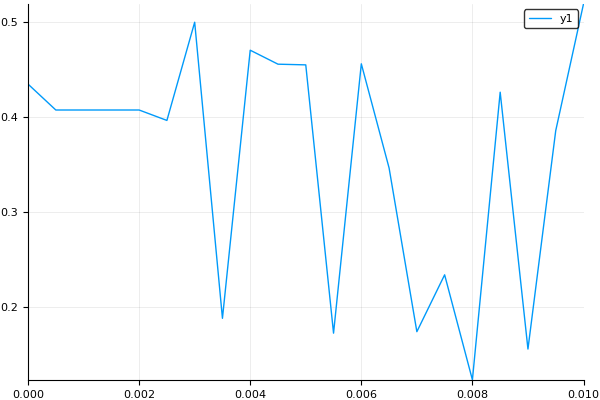

In [45]:
plot(U0_range, kurtosis_array)

In [25]:
function get_stats_dmghls(N, P, S, lambda, P_irr, beta, epsilon, len, loops=1000)
    kurtosis_array = Vector{Float64}(len)
    skewness_array = Vector{Float64}(len)
    dmghls = DMGHLS(N, P, S, lambda, P_irr, beta, epsilon=epsilon, seed=0)
    for i in 1:len
        dmghls = initialize_DMGHLS(dmghls, seed=i) # to save memory
        prices_dmghls = simulate!(dmghls, loops, seed=i)
        returns_dmghls = log.(prices_dmghls[2:end]) .- log.(prices_dmghls[1:(end-1)])
        kurtosis_array[i] = kurtosis(returns_dmghls[200:end])
        skewness_array[i] = skewness(returns_dmghls[200:end])
    end
    return kurtosis_array, skewness_array
end

get_stats_dmghls (generic function with 2 methods)

In [26]:
len = 500
kurtosis_array, skewness_array = get_stats_dmghls(N, P, S, lambda, P_irr, beta, epsilon, len, loops)

LoadError: [91mMethodError: no method matching DMGHLS(::Int64, ::Int64, ::Int64, ::Float64, ::Float64, ::Array{Float64,1}; epsilon=0.01, seed=0)[0m
Closest candidates are:
  DMGHLS(::Int64, ::Int64, ::Int64, ::Float64, ::Float64, [91m::Array{Float64,2}[39m) at /Users/neon/Desktop/S/Programming/Repositories/Graduate-Thesis/src/models.jl:43[91m got unsupported keyword arguments "epsilon", "seed"[39m
  DMGHLS(::Int64, ::Int64, ::Int64, ::Float64, ::Float64, [91m::Array{Float64,2}[39m, [91m::Array{Float64,1}[39m; price, seed) at /Users/neon/Desktop/S/Programming/Repositories/Graduate-Thesis/src/models.jl:43[91m got unsupported keyword argument "epsilon"[39m[39m

In [27]:
histogram(kurtosis_array)

LoadError: [91mInexactError()[39m


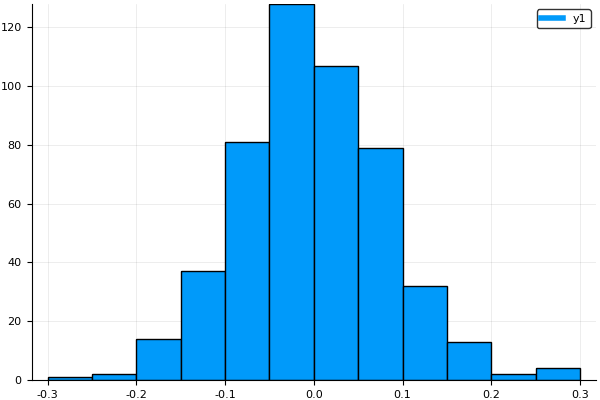

In [28]:
histogram(skewness_array)